In [2]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import regex as re
import numpy as np
import scipy

## Helper Functions

In [3]:
def plot_confusion_matrix(top_left, top_right, bottom_left, bottom_right, horizontal_label, vertical_label):
    array = [[top_left, top_right],
            [bottom_left, bottom_right]]
    array_df = pd.DataFrame(array, index=["pass", "fail"], columns=["pass", "fail"])
    sn.set(font_scale=1.6)
    h = sn.heatmap(array_df, annot=True, fmt='d')
    h.set_xlabel(horizontal_label)
    h.set_ylabel(vertical_label)

def write_tests_to_investigate(df, file_name):
    with open(f'/mnt/data/donald/pacsolve/slurm/test_results/{file_name}', 'w') as f:
        for name, row in df.iterrows():
            print("\n\n-----------------------------------\n\n", file=f)
            out = row.test_stdout.strip() if row.test_stdout is not None else None
            err = row.test_stderr.strip() if row.test_stderr is not None else None
            print(f"name = {name}\ntest_status = {row.test_status}\ntest_time = {row.test_time}\ntest_timeout = {row.test_timeout}\n\ntest_stdout =\n{out}\n\n\ntest_stderr = \n{err}", file=f)
    print(f"Saved test outputs to: /mnt/data/donald/pacsolve/slurm/test_results/{file_name}")

## Load Data

In [4]:
vanilla_df = pd.read_json('/mnt/data/donald/pacsolve/slurm/test_results/vanilla_top1000tarball_repos.json', orient='index')
vanilla_df.index.name = 'name'

minnpm_df = pd.read_json('/mnt/data/donald/pacsolve/slurm/test_results/minnpm_top1000tarball_repos_with_esm.json', orient='index')
minnpm_df.index.name = 'name'

In [14]:
print(vanilla_df.index[60:80])

Index(['cross-spawn.tgz', 'string.prototype.trimend.tgz',
       'crypto-random-string.tgz', 'querystringify.tgz', 'define-property.tgz',
       'rimraf.tgz', 'miller-rabin.tgz', 'is-ci.tgz', 'find-up.tgz',
       'remove-trailing-separator.tgz', 'yaml.tgz', 'postcss.tgz',
       'v8-to-istanbul.tgz', 'snapdragon.tgz', 'send.tgz', 'wide-align.tgz',
       'evp_bytestokey.tgz', 'path-key.tgz', 'node-libs-browser.tgz',
       'data-urls.tgz'],
      dtype='object', name='name')


In [15]:
minnpm_df.loc['assert.tgz', :]

root                                             top1000tarball_repos
solve_type                                                     minnpm
did_run_install                                                  True
did_run_build                                                    True
did_run_test                                                     True
skipped_esm                                                     False
has_build_script                                                 True
has_test_script                                                  True
install_status                                                    0.0
install_stdout      0 / 1\n100 / 88\n200 / 23\nSending query to ro...
install_stderr      npm WARN deprecated source-map-url@0.4.1: See ...
install_time                                                 34.53351
install_timeout                                                 False
build_status                                                      0.0
build_stdout        

## How many did we actually run tests on?

In [5]:
vanilla_ran = vanilla_df.did_run_test.sum()
minnpm_ran = minnpm_df.did_run_test.sum()
print(f"Vanilla ran {vanilla_ran} tests")
print(f"MinNPM ran {minnpm_ran} tests")

Vanilla ran 750 tests
MinNPM ran 736 tests


## How many tests passed (judged via exit code = 0)

In [6]:
vanilla_passed_idx = vanilla_df.did_run_test & (vanilla_df.test_status == 0)
vanilla_passed = vanilla_passed_idx.sum()
minnpm_passed = (minnpm_df[minnpm_df.did_run_test].test_status == 0).sum()
print(f"Vanilla passed {vanilla_passed} tests ({vanilla_passed / vanilla_ran * 100}%)")
print(f"MinNPM passed {minnpm_passed} tests ({minnpm_passed / minnpm_ran * 100}%)")

Vanilla passed 613 tests (81.73333333333333%)
MinNPM passed 571 tests (77.58152173913044%)


## Compute Num Tests Passed for each for Vanilla

In [83]:
vanilla_df['passed_tests'] = np.nan
p = re.compile(r'((?P<answer1>\d+) test passed)|((?P<answer2>\d+) passing)|(pass +(?P<answer3>\d+))|((?P<answer4>\d+) tests passed)|((?P<answer5>\d+) honored)|(passing: *(?P<answer6>\d+))|(total \.* \d+/(?P<answer7>\d+))|((?P<answer8>\d+) *tests)|((?P<answer9>\d+) *passed)|(Passed: *(?P<answer10>\d+))|(PASS: *(?P<answer11>\d+))|((?P<answer12>\d+) * test\(s\) passed)')
tap_pat = re.compile(r'^ *ok \d')
def extract_num_tests_from_log(log):
    if "TAP version 13" in log:
        return len(re.findall(tap_pat, log))
    elif "util@0.12.4 test" in log:
        return log.count("Testing ")
    elif "✔" in log:
        return log.count("✔")
    elif "✓" in log:
        return log.count("✓")
    else:
        m = p.search(log)
        if m is None:
            # print("ERROR:")
            # print(log)
            return np.nan
            # assert False
        
        # print(m)
        # print(m.groupdict())
        for x in m.groupdict().values():
            if x is not None:
                return int(x)
        assert False

vanilla_df.loc[vanilla_passed_idx, 'passed_tests'] = vanilla_df.loc[vanilla_passed_idx, 'test_stdout'].apply(extract_num_tests_from_log)

In [84]:
unmatched_rows = vanilla_df[vanilla_passed_idx & vanilla_df.passed_tests.isnull()]

for (name, stdout_txt) in unmatched_rows.iterrows():
    print(f"Name: {name}")
    print(stdout_txt.test_stdout)
    print("\n\n\n\n ---------------------------------- \n\n\n\n")
# print(unmatched_rows.test_stdout[13])

Name: source-map-url.tgz

> source-map-url@0.4.1 test
> npm run lint && npm run unit


> source-map-url@0.4.1 lint
> jshint source-map-url.js test/


> source-map-url@0.4.1 unit
> mocha






 ---------------------------------- 




Name: array-flatten.tgz

> array-flatten@3.0.0 test
> npm run build && npm run lint && npm run specs && npm run size


> array-flatten@3.0.0 build
> rimraf dist/ dist.es2015/ && tsc && tsc -P tsconfig.es2015.json


> array-flatten@3.0.0 lint
> tslint "src/**/*" --project tsconfig.json


> array-flatten@3.0.0 specs
> jest --coverage

----------|----------|----------|----------|----------|-------------------|
File      |  % Stmts | % Branch |  % Funcs |  % Lines | Uncovered Line #s |
----------|----------|----------|----------|----------|-------------------|
All files |      100 |      100 |      100 |      100 |                   |
 index.ts |      100 |      100 |      100 |      100 |                   |
----------|----------|----------|----------|--------

In [86]:
vanilla_df.passed_tests.isnull().sum()

276

## Comparing Passes / Fails with Vanilla and MinNPM

735 tests were ran by both Vanilla and MinNPM


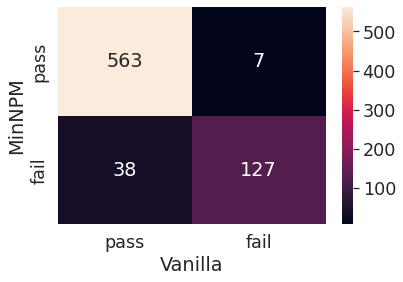

In [88]:
ran_by_both = vanilla_df.did_run_test & minnpm_df.did_run_test
ran_by_both_count = ran_by_both.sum()
print(f"{ran_by_both_count} tests were ran by both Vanilla and MinNPM")

vanilla_passes_minnpm_passes = ran_by_both & (vanilla_df.test_status == 0) & (minnpm_df.test_status == 0)
vanilla_fails_minnpm_passes = ran_by_both & (vanilla_df.test_status != 0) & (minnpm_df.test_status == 0)
vanilla_passes_minnpm_fails = ran_by_both & (vanilla_df.test_status == 0) & (minnpm_df.test_status != 0)
vanilla_fails_minnpm_fails = ran_by_both & (vanilla_df.test_status != 0) & (minnpm_df.test_status != 0)

plot_confusion_matrix(vanilla_passes_minnpm_passes.sum(), vanilla_fails_minnpm_passes.sum(), vanilla_passes_minnpm_fails.sum(), vanilla_fails_minnpm_fails.sum(), 'Vanilla', 'MinNPM')

## Comparing Test Number Stats

In [101]:
vanilla_df[vanilla_passes_minnpm_passes].passed_tests.describe()

count      482.000000
mean       489.369295
std       4699.011952
min          0.000000
25%          0.000000
50%          7.000000
75%         39.000000
max      81582.000000
Name: passed_tests, dtype: float64

In [98]:
vanilla_df[vanilla_passes_minnpm_fails].passed_tests.describe()

count      31.000000
mean       58.903226
std       266.872923
min         0.000000
25%         1.500000
50%         4.000000
75%        10.500000
max      1493.000000
Name: passed_tests, dtype: float64

In [106]:
scipy.stats.shapiro(vanilla_df[vanilla_passes_minnpm_fails].passed_tests.dropna())

ShapiroResult(statistic=0.21580898761749268, pvalue=9.480701813890935e-12)

In [107]:
scipy.stats.mannwhitneyu(vanilla_df[vanilla_passes_minnpm_passes].passed_tests.dropna(), vanilla_df[vanilla_passes_minnpm_fails].passed_tests.dropna())

MannwhitneyuResult(statistic=8021.5, pvalue=0.48792246733511124)

## Tests that Passed with Vanilla and Failed with MinNPM

In [8]:
tests_to_investigate_df = minnpm_df[vanilla_passes_minnpm_fails][['test_status', 'test_stdout', 'test_stderr', 'test_time', 'test_timeout']]
write_tests_to_investigate(tests_to_investigate_df, 'tests_to_inspect.txt')
tests_to_investigate_df

Saved test outputs to: /mnt/data/donald/pacsolve/slurm/test_results/tests_to_inspect.txt


,test_status,test_stdout,test_stderr,test_time,test_timeout
name,,,,,
parse-json.tgz,1.0,\n> parse-json@6.0.2 test\n> xo && nyc ava\n\n,Error: Failed to load plugin 'unicorn' declare...,1.221200,0.0
strip-ansi.tgz,1.0,\n> strip-ansi@7.0.1 test\n> xo && ava && tsd\n\n,/tmp/tmp3h0u6hkg/package/node_modules/strip-an...,0.777600,0.0
aggregate-error.tgz,1.0,\n> aggregate-error@4.0.1 test\n> ava && tsd\n\n,/tmp/tmp0e54bzhs/package/node_modules/aggregat...,0.369292,0.0
eslint-plugin-import.tgz,66.0,\n> eslint-plugin-import@2.26.0 pretest\n> lin...,\nLinked 6 dependencies\n\nError while parsing...,39.380328,0.0
cli-cursor.tgz,1.0,\n> cli-cursor@4.0.0 test\n> xo && ava && tsd\n\n,/tmp/tmpqa3azyrf/package/node_modules/cli-curs...,5.137375,0.0
wrap-ansi.tgz,1.0,\n> wrap-ansi@8.0.1 test\n> xo && nyc ava\n\n,/tmp/tmp4rl5q0vq/package/node_modules/eslint-f...,0.809373,0.0
npm-run-path.tgz,1.0,\n> npm-run-path@5.1.0 test\n> xo && ava && ts...,/tmp/tmpf23znx63/package/node_modules/cross-sp...,0.823386,0.0
p-locate.tgz,1.0,\n> p-locate@6.0.0 test\n> xo && ava && tsd\n\n,/tmp/tmpr6f2aeey/package/node_modules/pkg-dir/...,0.968923,0.0
onetime.tgz,1.0,\n> onetime@6.0.0 test\n> xo && ava && tsd\n\n,/tmp/tmpazria0ps/package/node_modules/mem/dist...,4.306078,0.0


In [9]:
tests_to_investigate_df = vanilla_df[vanilla_fails_minnpm_passes][['test_status', 'test_stdout', 'test_stderr', 'test_time', 'test_timeout']]
write_tests_to_investigate(tests_to_investigate_df, 'tests_to_inspect2.txt')
tests_to_investigate_df

Saved test outputs to: /mnt/data/donald/pacsolve/slurm/test_results/tests_to_inspect2.txt


,test_status,test_stdout,test_stderr,test_time,test_timeout
name,,,,,
neo-async.tgz,1.0,\n> neo-async@2.6.2 test\n> istanbul cover ./n...,error\nlog\ntest\n============================...,35.753817,0.0
get-intrinsic.tgz,1.0,\n> get-intrinsic@1.1.2 pretest\n> npm run lin...,evalmd info it worked if it ends with ok\neval...,0.774891,0.0
array.prototype.flat.tgz,1.0,\n> array.prototype.flat@1.3.0 pretest\n> npm ...,evalmd info it worked if it ends with ok\neval...,1.657289,0.0
array-includes.tgz,1.0,\n> array-includes@3.1.5 pretest\n> npm run --...,evalmd info it worked if it ends with ok\neval...,0.791687,0.0
bl.tgz,1.0,\n> bl@5.0.0 test\n> npm run lint && node test...,node:internal/fs/utils:344\n throw err;\n ...,3.949296,0.0
call-bind.tgz,1.0,\n> call-bind@1.0.2 pretest\n> npm run lint\n\...,evalmd info it worked if it ends with ok\neval...,1.498611,0.0
mimic-response.tgz,1.0,\n> mimic-response@4.0.0 test\n> xo && ava && ...,,6.436579,0.0
